# Near-surface Air Temperature (tas)
conda env: new `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 31 GB / available: 16 GB / percent used: 45.7 %


In [48]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=slice(10,50)
lonlim=slice(60,110)

## Load elevation file

In [3]:
path = '/home/lalandmi/Dropbox/data/GMTED2010/'
ds = xr.open_dataset(path+'GMTED2010_15n120_0500deg.nc') \
    .drop_dims('nbounds') \
    .swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
    .drop({'nlat', 'nlon'}) \
    .rename({'latitude': 'lat', 'longitude': 'lon'}) \
    .sel(lat=latlim, lon=lonlim)

elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Open CRU

In [23]:
ds = xr.open_dataset('/home/lalandmi/Dropbox/data/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc') \
        .sel(time=period, lat=latlim, lon=lonlim)
ds

<xarray.Dataset>
Dimensions:  (lat: 50, lon: 100, time: 408)
Coordinates:
  * lon      (lon) float32 60.25 60.75 61.25 61.75 ... 108.75 109.25 109.75
  * lat      (lat) float32 20.25 20.75 21.25 21.75 ... 43.25 43.75 44.25 44.75
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2014-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.04 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2004151855. Data generated from:tmp.2004011744.dtb
    history:      Wed 15 Apr 2020 19:58:33 BST : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

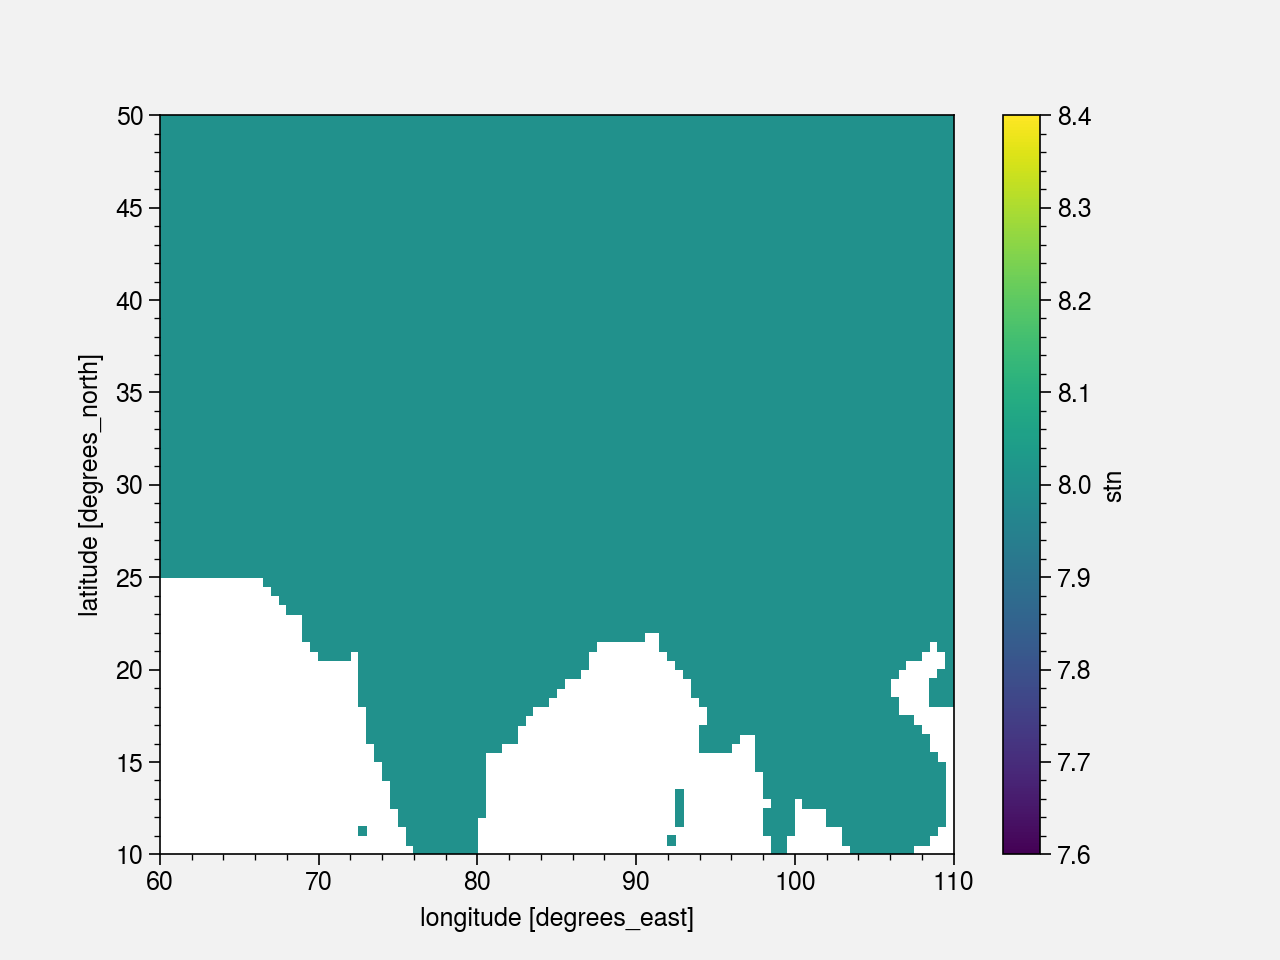

In [29]:
ds.stn.min('time').plot()

In [5]:
cru = ds.tmp
cru

<xarray.DataArray 'tmp' (time: 408, lat: 80, lon: 100)>
[3264000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 60.25 60.75 61.25 61.75 ... 108.75 109.25 109.75
  * lat      (lat) float32 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2014-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


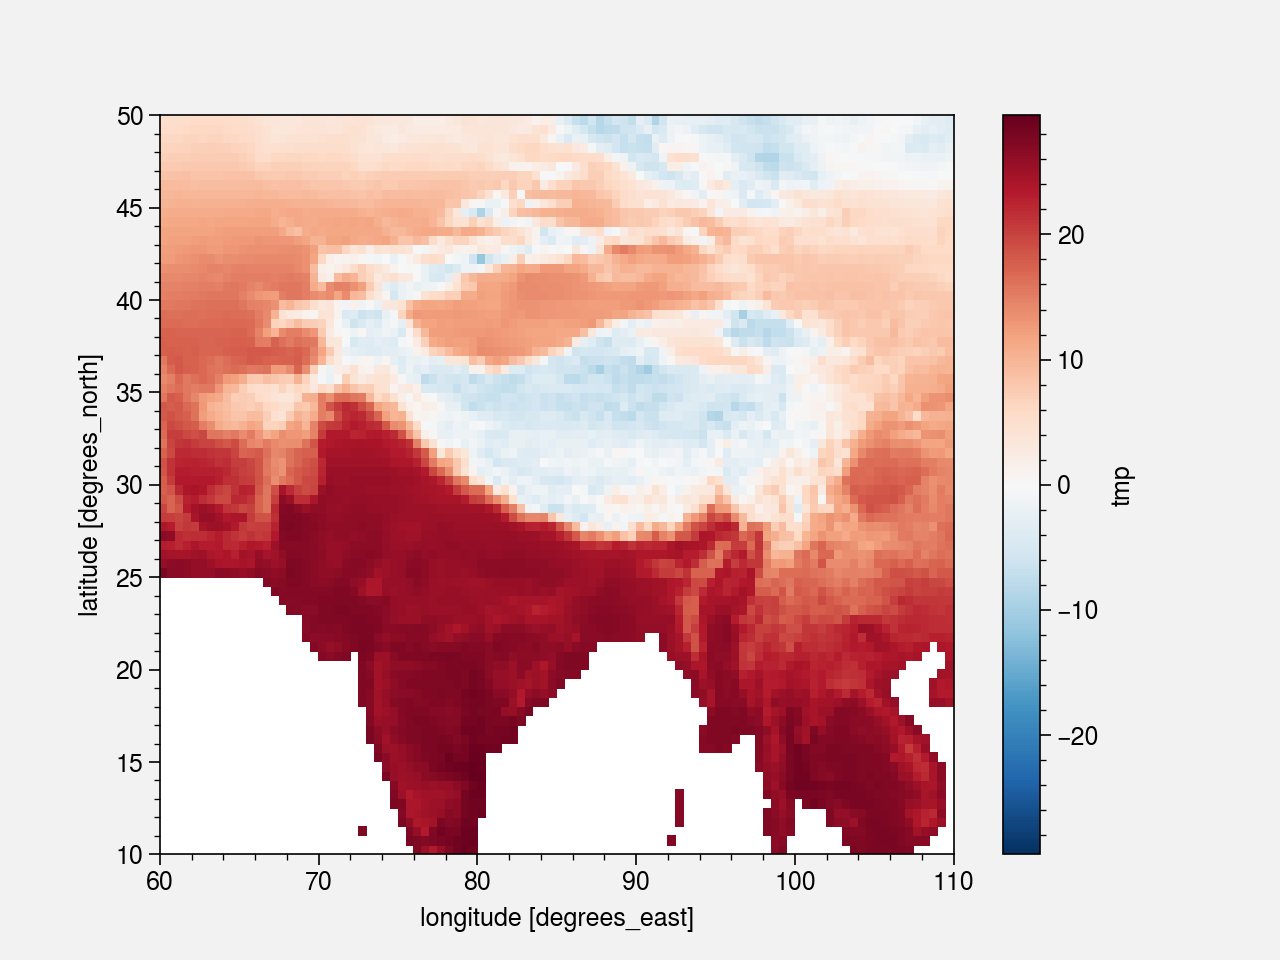

In [32]:
cru.mean('time').plot()

In [6]:
cru_mon = cru.groupby('time.month').mean()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


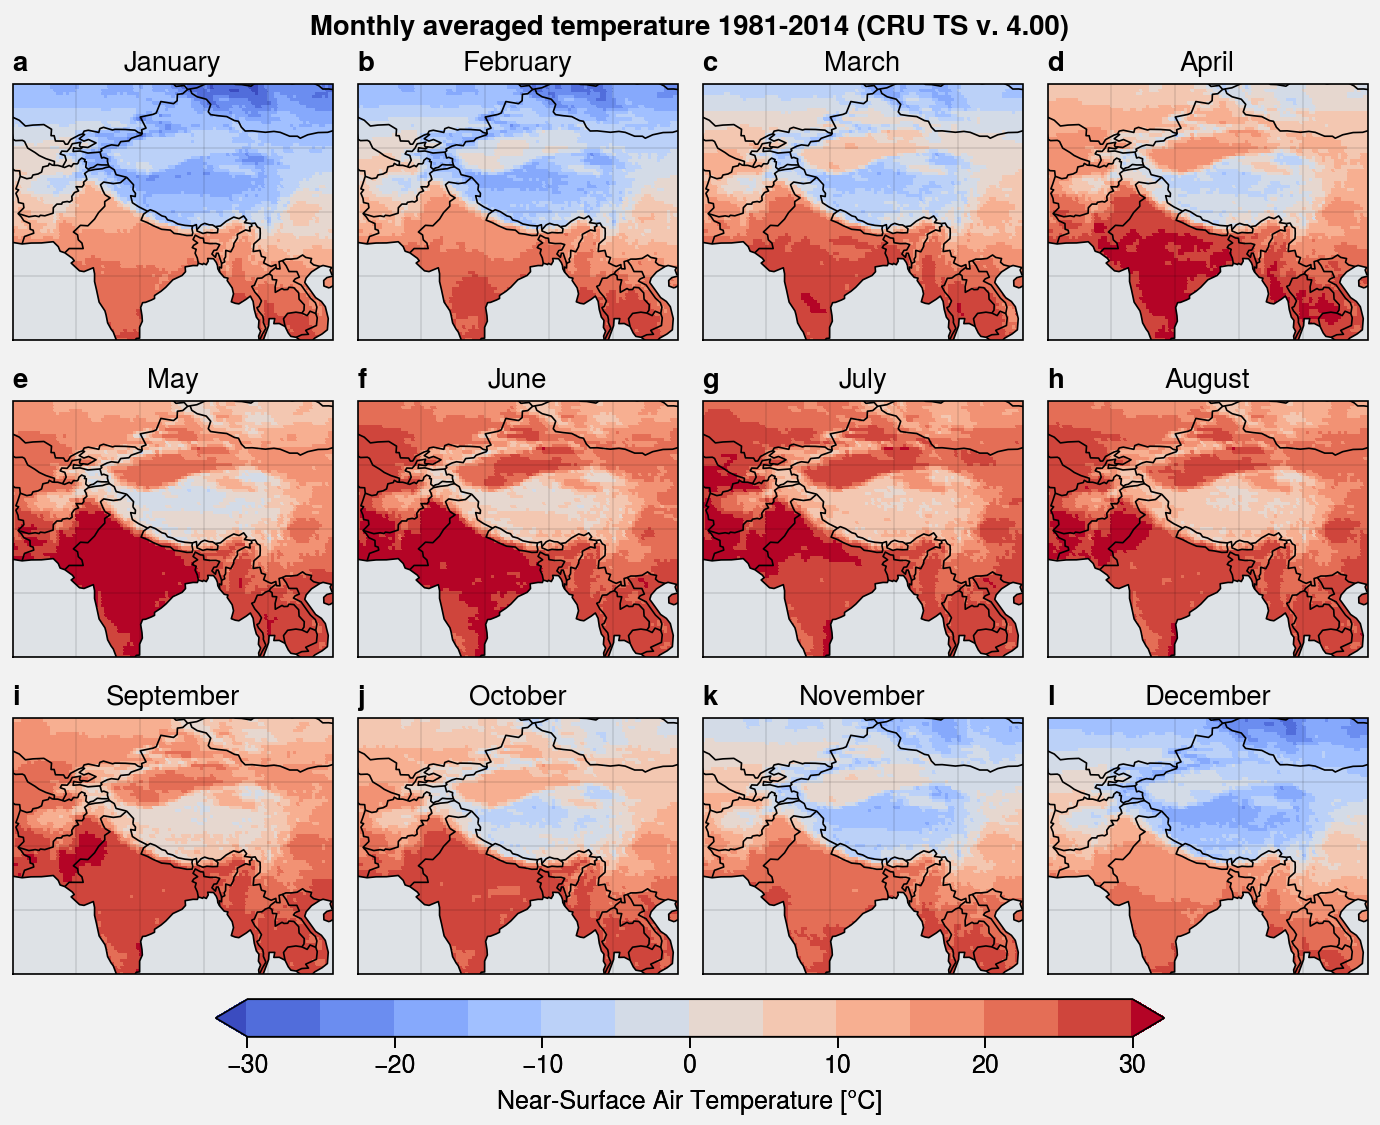

In [51]:
cmap='CoolWarm'
levels=plot.arange(-30,30,5)

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=1.6)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        cru_mon.isel(month=i), 
        cmap=cmap,  
        levels=levels,
        extend='both'
    )
    ax.format(title=calendar.month_name[i+1])
    
f.colorbar(m, label='Near-Surface Air Temperature [°C]', loc='b', length=0.7)

axs.format(
    labels=False, coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Monthly averaged temperature 1981-2014 (CRU TS v. 4.00)',
    lonlines=10, latlines=10, abc=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

for ext in ['jpg', 'pdf']:
    f.save('img/cru_mon_1981-2014.'+ext)

## Open APHRODITE
http://aphrodite.st.hirosaki-u.ac.jp/download/  
V1808	daily temperature	MA	mixed	0.25, 0.50	1961 - 2015  
Dowloaded: 19/08/2022 Mickaël Lalande

In [52]:
path = '/home/lalandmi/Dropbox/data/APHRODITE/APHRO_MA_TAVE_050deg_V1808.nc/050_nc'
ds = xr.open_mfdataset(path+'/APHRO_MA_TAVE_050deg_V1808.*.nc') \
        .sel(time=period, lat=latlim, lon=lonlim)
ds

,Array,Chunk
Bytes,397.38 MB,11.71 MB
Shape,"(12418, 80, 100)","(366, 80, 100)"
Count,199 Tasks,34 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,397.38 MB,11.71 MB
Shape,"(12418, 80, 100)","(366, 80, 100)"
Count,199 Tasks,34 Chunks
Type,float32,numpy.ndarray


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


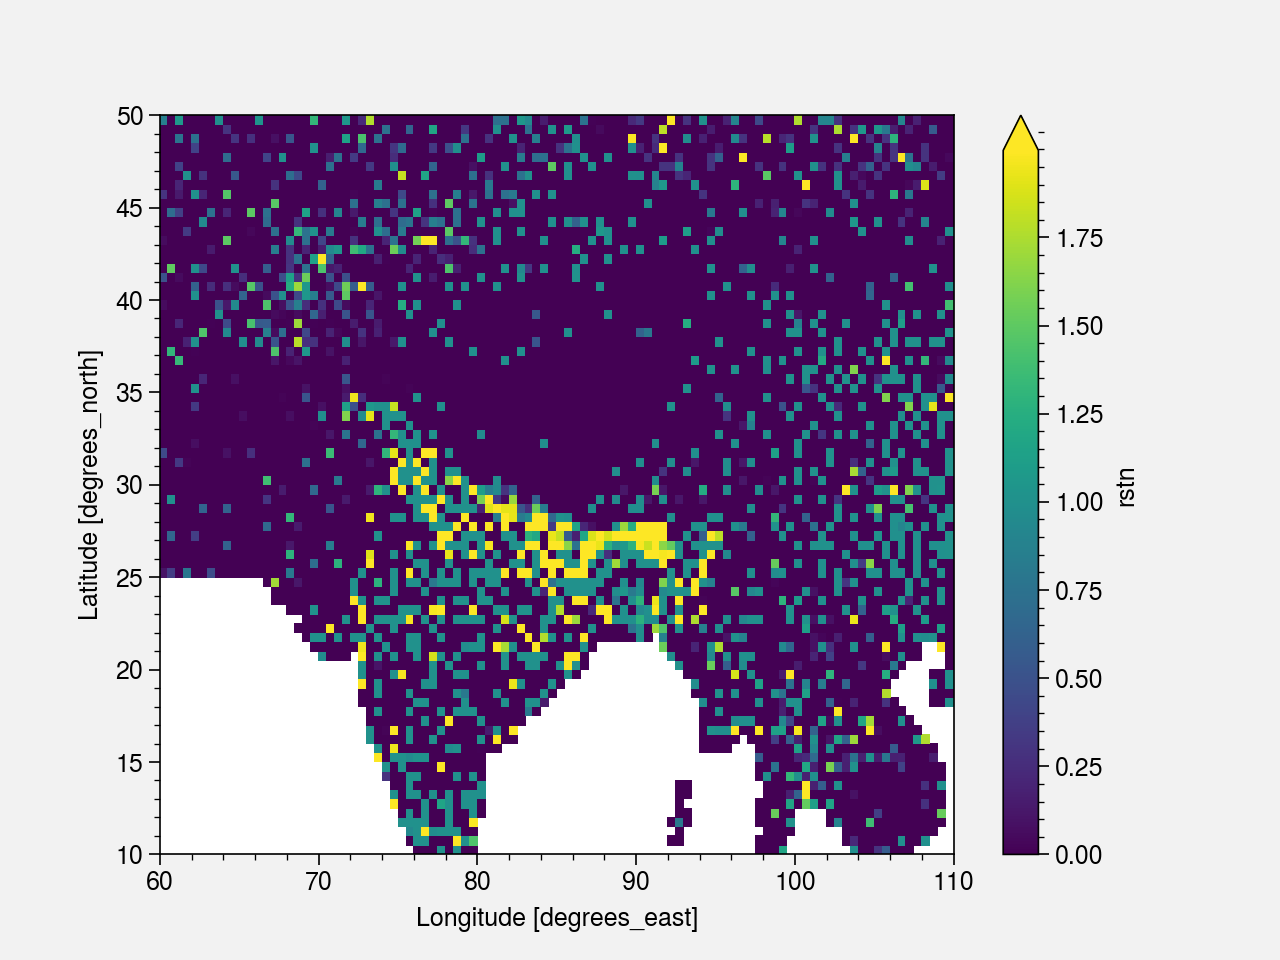

In [79]:
ds.rstn.mean('time').plot(robust=True)

2.4  Missing Code

   Daily mean temperature :  -99.9
   Ratio of 0.05 grid box containing station(s) :  -99.9
   
-> no missing values

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


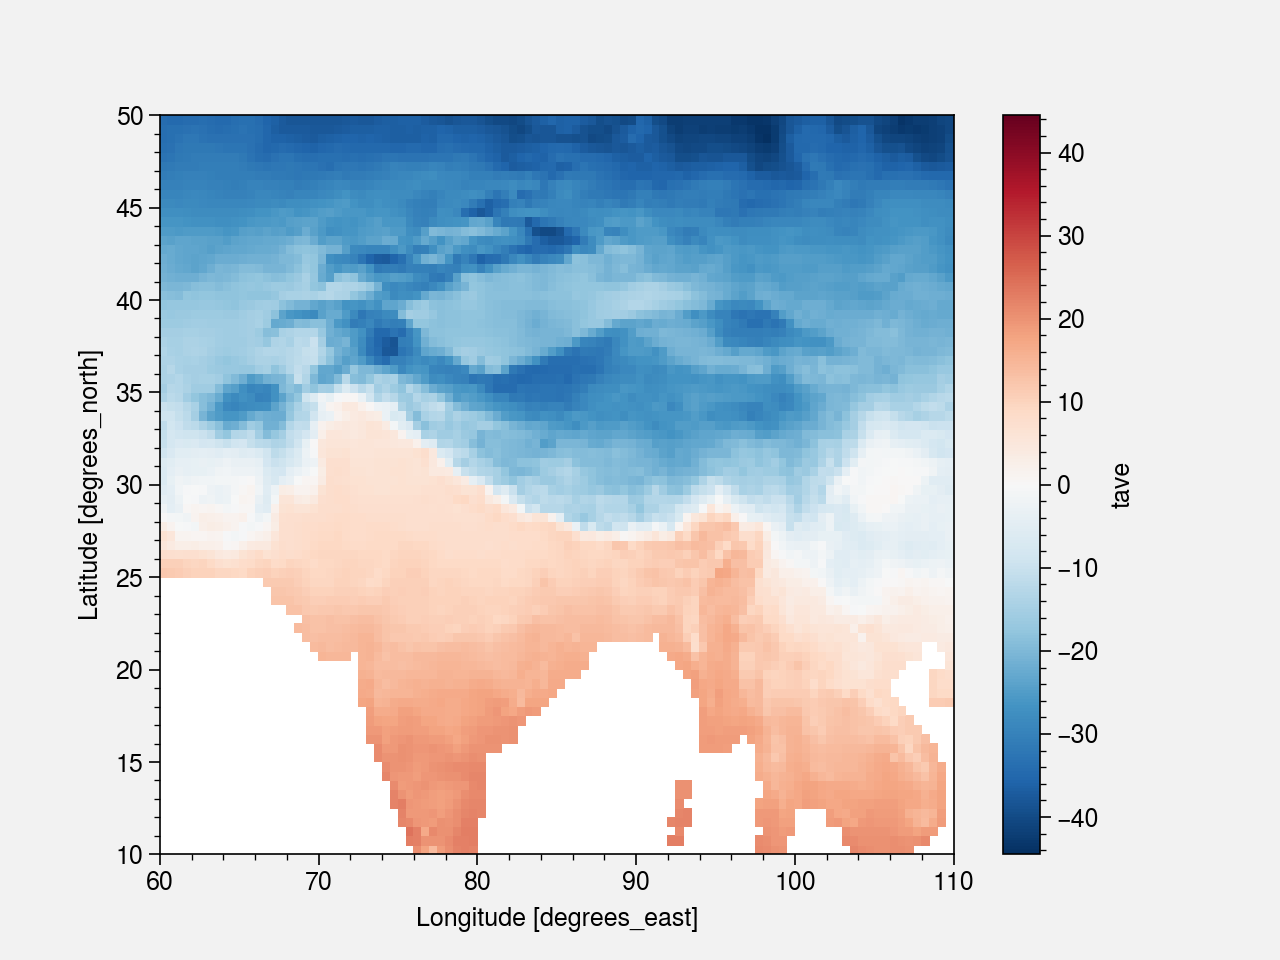

In [56]:
ds.tave.min('time').plot()

In [8]:
aphro = ds.tave.resample(time='M').mean()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


## Load CMFD

In [9]:
path = '/home/lalandmi/Dropbox/data/TPDC/china_meteorological_forcing_dataset_1979_2018/Data_forcing_01mo_010deg/'

ds = xr.open_dataset(path+'temp_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc')
cmfd = ds.temp.sel(time=period, lat=latlim, lon=lonlim)
cmfd -= 273.15

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


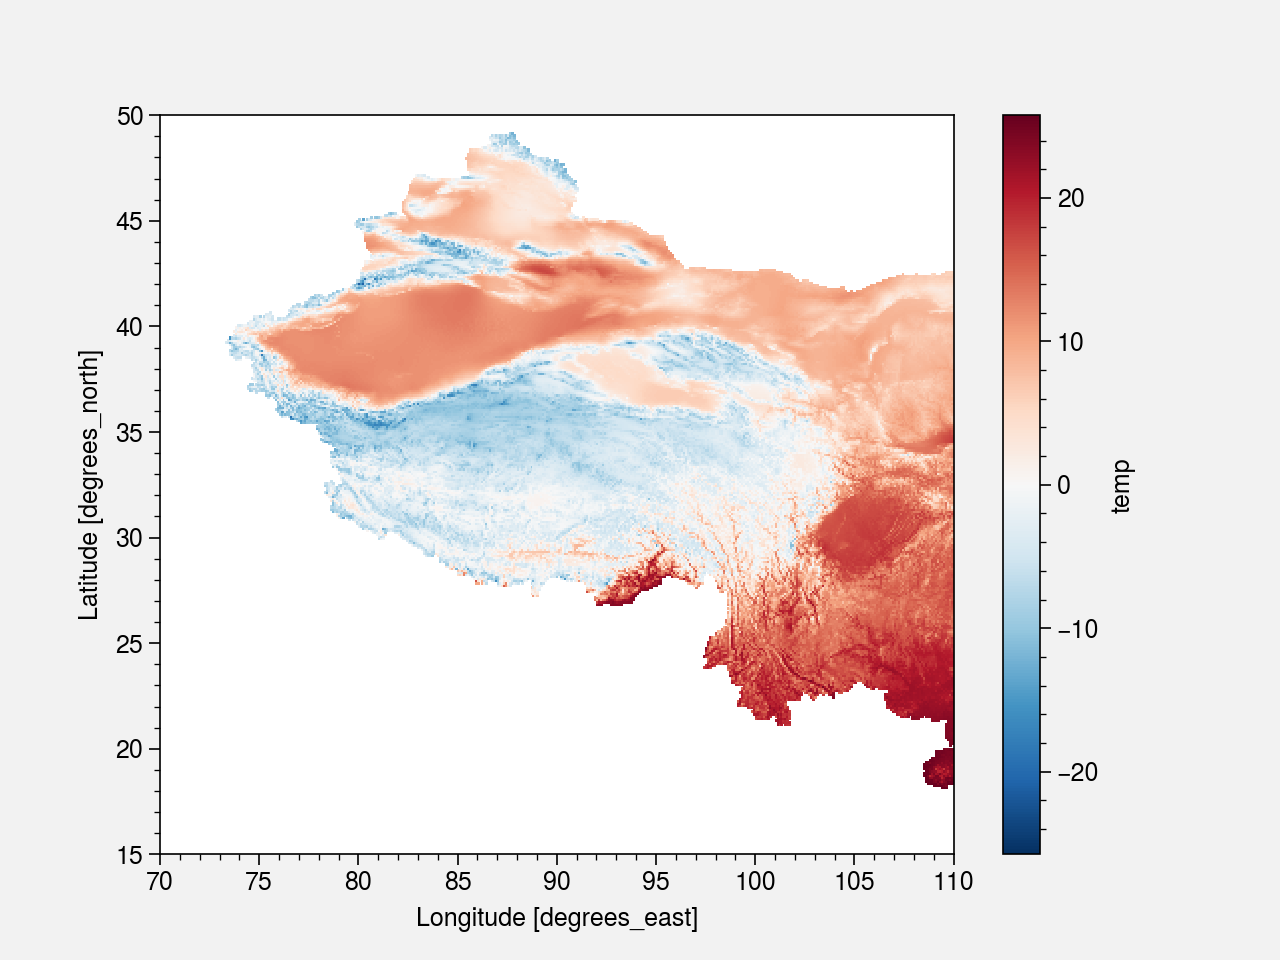

In [83]:
cmfd.mean('time').plot()

## Regrid

In [31]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

In [37]:
regridder = xe.Regridder(cmfd, cru, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
cmfd_regrid = regridder(cmfd)

Create weight file: bilinear_350x400_80x100.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Plot

In [46]:
u.get_domain_HMA()

(slice(20, 45, None), slice(60, 110, None))

In [12]:
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

In [17]:
aphro

,Array,Chunk
Bytes,13.06 MB,32.00 kB
Shape,"(408, 80, 100)","(1, 80, 100)"
Count,1831 Tasks,408 Chunks
Type,float32,numpy.ndarray


In [38]:
cru_seas = cru.groupby('time.season').mean('time').load()
aphro_seas = aphro.groupby('time.season').mean('time').load()
cmfd_seas = cmfd.groupby('time.season').mean('time').load()
cmfd_regrid_seas = cmfd_regrid.groupby('time.season').mean('time').load()

obs_list = [
    cru_seas, aphro_seas, cmfd_seas,
    aphro_seas - cru_seas, cmfd_regrid_seas - cru_seas
]

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [32]:
cmfd_seas

<xarray.DataArray 'temp' (season: 4, lat: 350, lon: 400)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 15.05 15.150001 15.25 15.35 ... 49.75 49.85 49.95
  * lon      (lon) float32 70.05 70.15 70.25 ... 109.75 109.850006 109.950005
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

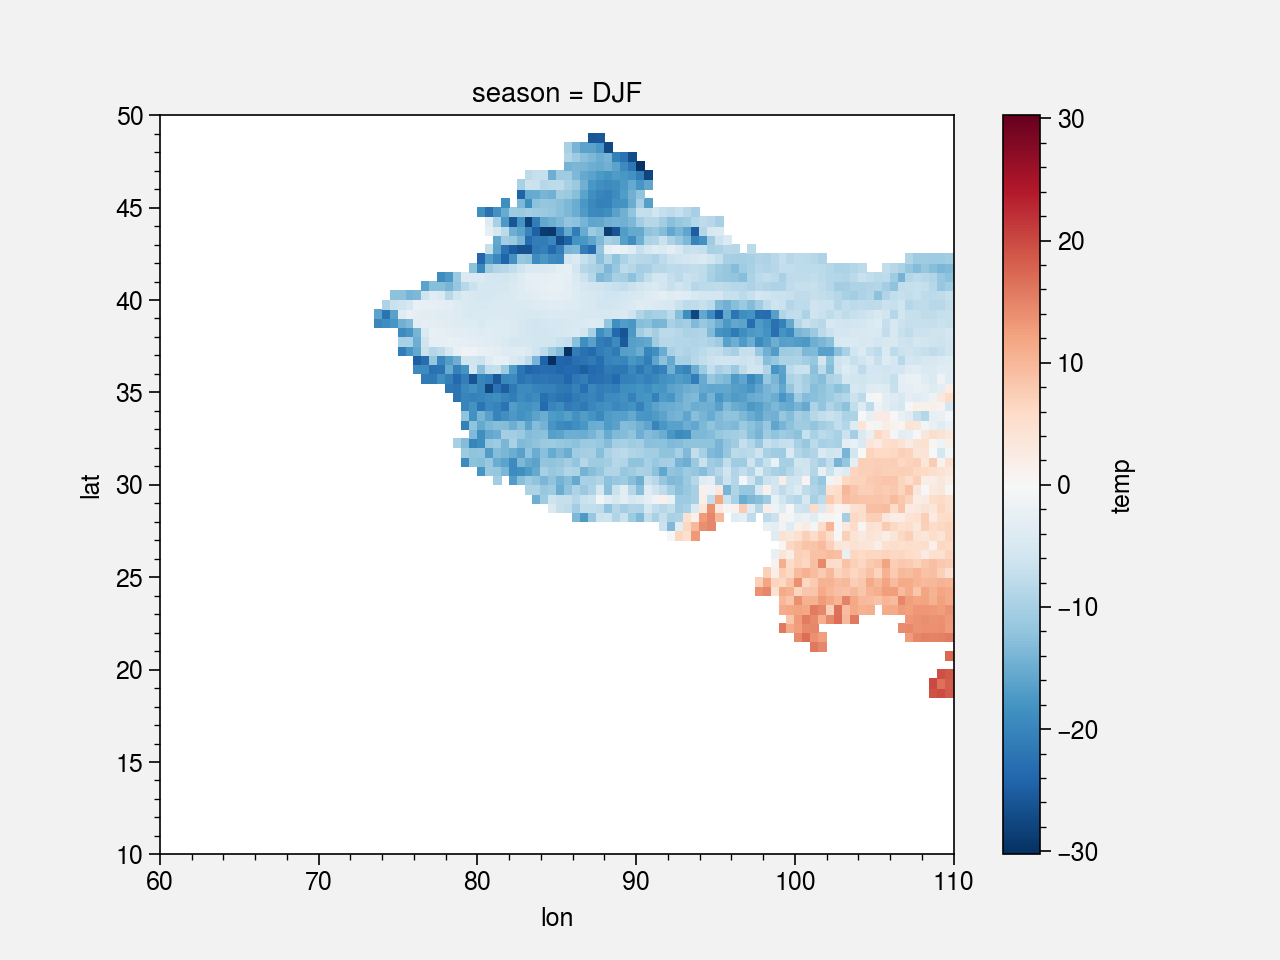

In [40]:
cmfd_regrid_seas[0].plot()

In [27]:
aphro_seas

<xarray.DataArray 'tave' (season: 4, lat: 80, lon: 100)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  23.66813   ,
                  nan,          nan],
        ...,
        [-12.093044  , -12.253052  , -12.220078  , ..., -24.476845  ,
         -24.235193  , -22.871716  ],
        [-12.576725  , -12.871201  , -12.939735  , ..., -23.64129   ,
         -23.852049  , -23.347523  ],
        [-13.097909  , -13.268889  , -13.436739  , ..., -23.940891  ,
         -23.268885  , -23.541193  ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  26.334314  ,
                  nan,          nan],
...
        [  6.3052955 ,   6.4182754 ,   6.6555066 , ...,  -2.3035586 ,
          -2.5064175 ,  -1.3942862 ],
        [  5.6903315 ,   5.6453333 ,   5.8029857 , ...,  -0.89698446,
          -1.8827326 ,  -2.221271  ],
        [  4.994802  ,   5.013405  ,   5.0580177 , ...,  -1.2958908 ,
          -1.1303991 ,  -2.44016   ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  25.515875  ,
                  nan,          nan],
        ...,
        [  6.357079  ,   6.447183  ,   6.661603  , ...,  -4.3041544 ,
          -4.462761  ,  -3.4566298 ],
        [  5.8996186 ,   5.846273  ,   5.9948072 , ...,  -3.0822334 ,
          -3.9735405 ,  -4.2611513 ],
        [  5.328878  ,   5.3671246 ,   5.4394865 , ...,  -3.4654143 ,
          -3.3157952 ,  -4.472585  ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 108.2 108.8 109.2 109.8
  * lat      (lat) float64 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [30]:
cru_seas

<xarray.DataArray 'tmp' (season: 4, lat: 80, lon: 100)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  24.442156 ,
                 nan,         nan],
        ...,
        [-12.189217 , -12.413726 , -12.460784 , ..., -23.230394 ,
         -23.365685 , -22.508818 ],
        [-12.751961 , -13.087257 , -13.178432 , ..., -21.972551 ,
         -22.450981 , -22.845095 ],
        [-13.071567 , -13.417648 , -13.561768 , ..., -22.468622 ,
         -22.34902  , -22.985289 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  27.444126 ,
                 nan,         nan],
...
        [  6.701959 ,   6.807843 ,   6.95196  , ...,  -2.4509804,
          -2.6303923,  -1.5529414],
        [  6.1568623,   6.068628 ,   6.1872544, ...,  -0.7568629,
          -1.4941173,  -2.0225487],
        [  5.819608 ,   5.700981 ,   5.7215695, ...,  -1.4803919,
          -1.3676465,  -2.2941175]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  26.252941 ,
                 nan,         nan],
        ...,
        [  6.7205877,   6.887256 ,   7.1      , ...,  -3.8392174,
          -3.9941175,  -2.9931371],
        [  6.264705 ,   6.2588224,   6.3411775, ...,  -2.2529418,
          -2.9303925,  -3.3960783],
        [  5.8980393,   5.826471 ,   5.892158 , ...,  -2.871568 ,
          -2.732353 ,  -3.5323524]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 60.25 60.75 61.25 61.75 ... 108.75 109.25 109.75
  * lat      (lat) float32 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [26]:
cmfd_seas

<xarray.DataArray 'temp' (season: 4, lat: 350, lon: 400)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 15.05 15.150001 15.25 15.35 ... 49.75 49.85 49.95
  * lon      (lon) float32 70.05 70.15 70.25 ... 109.75 109.850006 109.950005
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

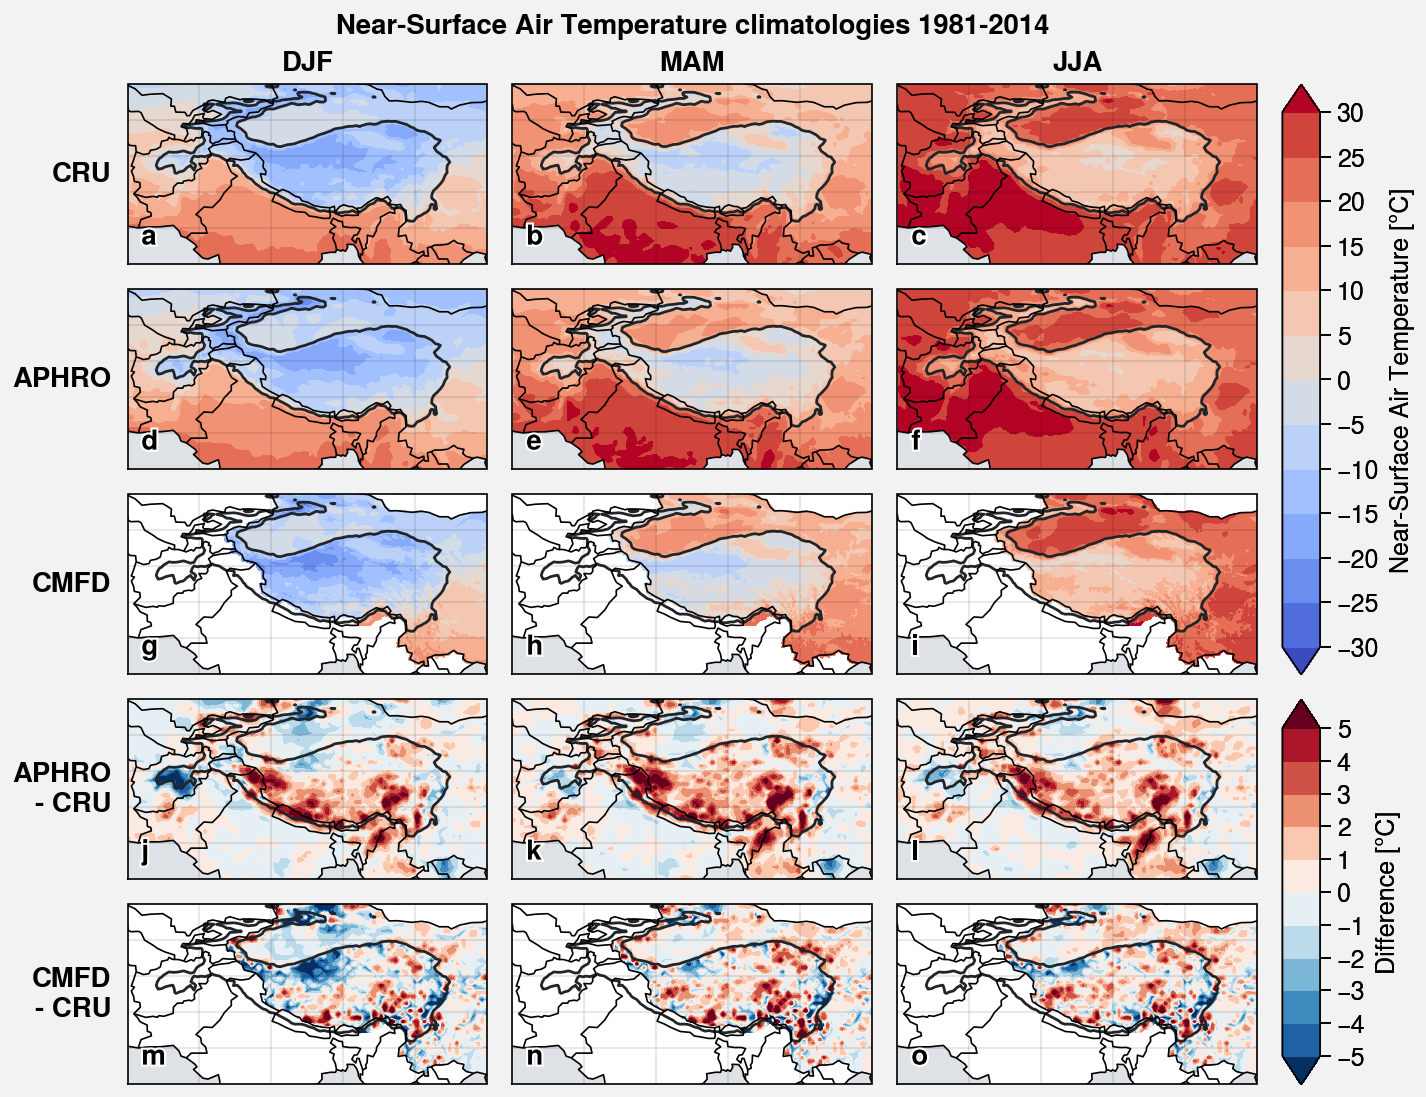

In [45]:
# seasons = ['SON', 'DJF', 'MAM', 'JJA']
seasons = ['DJF', 'MAM', 'JJA']
var = 'tas'

label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)


# obs_list_names = ['CRU', 'CMFD', 'CRU - CMFD']
obs_list_names = ['CRU', 'APHRO', 'CMFD', 'APHRO\n- CRU', 'CMFD\n- CRU']

fig, axs = plot.subplots(ncols=len(seasons), nrows=len(obs_list), proj='cyl', axwidth=1.8)

k = 0

for i, obs in enumerate(obs_list):
    for season in seasons:
        
        if i in [0, 1, 2]:
            m1 = axs[k].contourf(obs.sel(season=season), cmap=cmap, levels=levels, extend='both')
        else:
            m2 = axs[k].contourf(obs.sel(season=season), cmap=cmap_diff, levels=levels_diff, extend='both')
        k += 1


# fig.colorbar(m, label='Snow Cover Extent [%]') 
fig.colorbar(m1, label=label+' ['+units+']', loc='r', rows=(1,3))
fig.colorbar(m2, label='Difference ['+units+']', loc='r', rows=(4,5))

for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=obs_list_names, collabels=seasons,
    suptitle=label+' climatologies '+period.start+'-'+period.stop
)

for ext in ['jpg', 'pdf']:
    fig.save('img/tas_comparison_seas_1981-2014.'+ext)